In [1]:
# load all the library we needed
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from sklearn.preprocessing import power_transform
import random

In [2]:
#### train.csv
#building_id - Foreign key for the building metadata.
#meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, hotwater: 3}. Not every building has all meter types.
#timestamp - When the measurement was taken
#meter_reading - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error. 

#### building_meta.csv
#site_id - Foreign key for the weather files.
#building_id - Foreign key for training.csv
#primary_use - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
#square_feet - Gross floor area of the building
#year_built - Year building was opened
#floorcount - Number of floors of the building 

#### weather[train/test].csv Weather data from a meteorological station as close as possible to the site.
#site_id
#air_temperature - Degrees Celsius
#cloud_coverage - Portion of the sky covered in clouds, in oktas
#dew_temperature - Degrees Celsius
#precip_depth_1_hr - Millimeters
#sea_level_pressure - Millibar/hectopascals
#wind_direction - Compass direction (0-360)
#wind_speed - Meters per second

#### test.csv
#The submission files use row numbers for ID codes in order to save space on the file uploads. test.csv has no feature data; it exists so you can get your predictions into the correct order.
#row_id - Row id for your submission file
#building_id - Building id code
#meter - The meter id code
#timestamp - Timestamps for the test data period

#### sample_submission.csv
#A valid sample submission.

In [3]:
# load all data from resources
df_train = pd.read_csv('../Resources/train.csv')
# df_test = pd.read_csv('../Resources/test.csv')
df_building = pd.read_csv('../Resources/building_metadata.csv')
# df_sample = pd.read_csv('../Resources/sample_submission.csv')
df_weather_test = pd.read_csv('../Resources/weather_test.csv')
df_weather_train = pd.read_csv('../Resources/weather_train.csv')
df_train_merge = pd.read_csv('../Resources/train_merge.csv')

In [4]:
# try to process data to make the timestamp more sence by using to_datetime
def df_process(df, verbose = True):
    try:
        df["timestamp"] = pd.to_datetime(df["timestamp"], format='%Y-%m-%d %H:%M:%S')
    except:
        print('There is no timestamp column')
    # reduce memory
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'\
                      .format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
# process the data
csv_list = ['train.csv', 'building_metadata.csv', 'weather_test.csv', 'weather_train.csv', 'train_merge.csv']
df_train = df_process(df_train)
# df_test = df_process(df_test)
df_building = df_process(df_building)
# df_sample_sub = df_process(df_sample_submission)
df_weather_test = df_process(df_weather_test)
df_weather_train = df_process(df_weather_train)
df_train_merge = df_process(df_train_merge)
df_post_list = [df_train, df_building, df_weather_test, df_weather_train, df_train_merge]

Mem. usage decreased to 289.19 Mb (53.1% reduction)
There is no timestamp column
Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to 1041.10 Mb (64.5% reduction)


In [6]:
# # make normal and log of meter_reading column
# df_train['meter_reading_normal'] = power_transform(np.array(df_train['meter_reading'] + 1).reshape(-1,1), method = 'yeo-johnson')
# df_train['meter_reading_log'] = np.log(df_train['meter_reading'] + 1)
# # merge all the data together for training set first
# df_train_merge = pd.merge(df_train, df_building, on='building_id', how='left')
# df_train_merge = pd.merge(df_train_merge, df_weather_train, on=['site_id', 'timestamp'], how='left')
# df_train_merge.to_csv('../Resources/train_merge.csv')

In [7]:
# merge all the data together for training set first
# df_train_merge = pd.merge(df_train, df_building, on='building_id', how='left')
# df_train_merge = pd.merge(df_train_merge, df_weather_train, on=['site_id', 'timestamp'], how='left')
# df_train_merge.to_csv('../Resources/train_merge.csv', index = False)

In [8]:
%%capture cap1 --no-stderr
# print out the basical information of the dataframe including column name and shape
def basic_print(name, df):
    print(name + "'s columns name are: " + str(list(df.columns)))
    print(name + "'s shape is " + str(df.shape))
    print('-'*30)
for i in range(len(csv_list)):
    df_post_list[i].name = csv_list[i]
    basic_print(csv_list[i], df_post_list[i])
with open('./Output/txt/basic_info.txt', 'w') as f:
    f.write(cap1.stdout)

NameError: name 'cap1' is not defined

In [9]:
%%capture cap2 --no-stderr
def main_print(df):
    print(str(df.name) + "'s basic information:")
    print('head:')
    print(df.head())
    print('describe:')
    print(df.describe())
    print('dtypes:')
    print(df.dtypes)
    df_missing = df.isnull().sum(axis = 0).reset_index()
    df_missing = df_missing.rename(columns = {'index': 'column_name', 0: 'total_missing'})
    df_missing['missing_percentage'] = df_missing['total_missing'].divide(df.shape[0]/100)
    print(df_missing.sort_values('missing_percentage', ascending = False).reset_index(drop = True))
    if 'timestamp' in df.columns:
        print()
        print('the max of timestamp is ' + str(df['timestamp'].max()))
        print('the min of timestamp is ' + str(df['timestamp'].min()))
    print('-'*30)
for i in df_post_list:
    main_print(i)
with open('./Output/txt/detail_info.txt', 'w') as f:
    f.write(cap2.stdout)

NameError: name 'cap2' is not defined

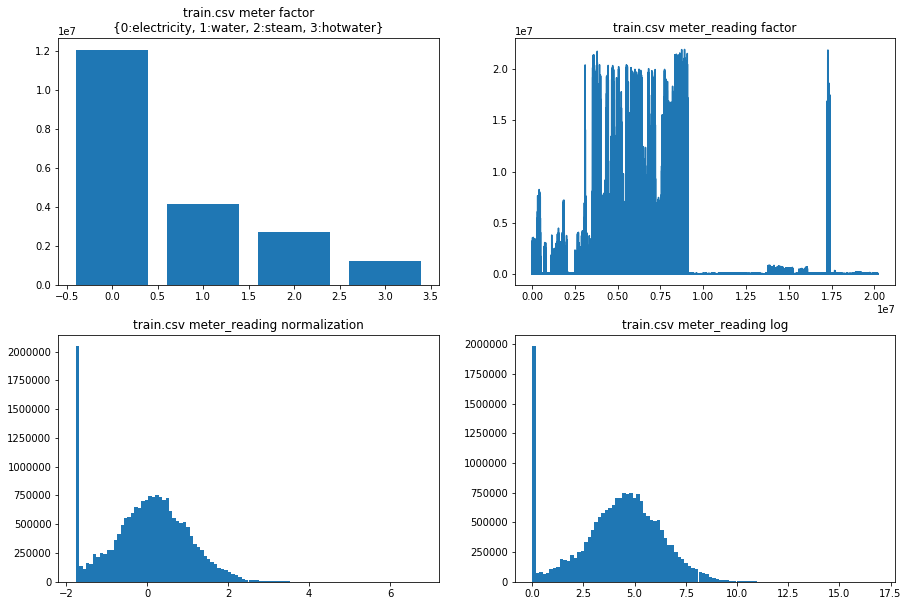

In [10]:
# to check all the data, here is several plot for different factors
# check the factors for train.csv by plot
fig, ((axe1, axe2),(axe3, axe4)) = plt.subplots(2, 2, sharex = False, sharey = False, figsize = (15,10))
df_train_meter = df_train['meter'].value_counts()
axe1.bar([0,1,2,3], height = df_train_meter)
axe1.set_title('train.csv meter factor\n{0:electricity, 1:water, 2:steam, 3:hotwater}')
axe2.plot(df_train_merge['meter_reading'])
axe2.set_title('train.csv meter_reading factor')
axe3.hist(df_train_merge['meter_reading_normal'], bins = 100)
axe3.set_title('train.csv meter_reading normalization')
axe4.hist(df_train_merge['meter_reading_log'], bins = 100)
axe4.set_title('train.csv meter_reading log')
plt.savefig("./Output/png/train_factors.png", bbox_inches = 'tight', dpi = 300)
plt.show()

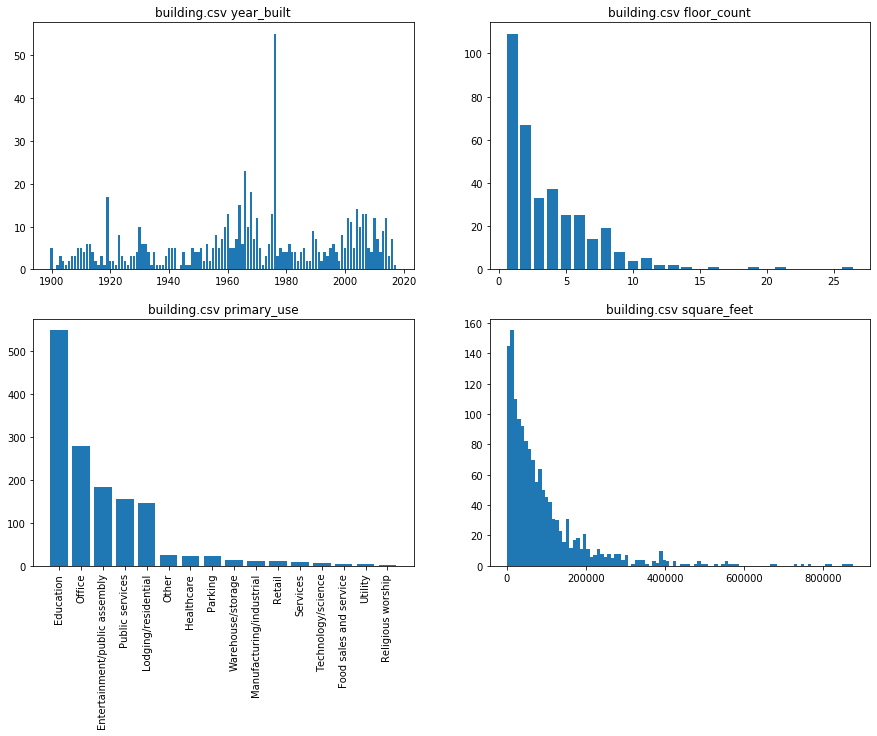

In [11]:
# draw the building factors
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharex = False, sharey = False, figsize = (15,10))
ax_list = [ax1,ax2,ax3]
building_list = ['year_built', 'floor_count', 'primary_use']
for i in range(3):
    df_inside = df_building[building_list[i]].value_counts()
    df_inside = df_inside.rename_axis('x').reset_index(name = 'y')
    ax_list[i].bar(df_inside['x'], df_inside['y'])
    ax_list[i].set_title('building.csv ' + building_list[i])
ax3.set_xticklabels(labels = df_inside['x'], rotation=90)
ax4.hist(df_building['square_feet'], bins = 100)
ax4.set_title('building.csv square_feet')
plt.savefig("./Output/png/building_factors.png", bbox_inches = 'tight', dpi = 300)
plt.show()

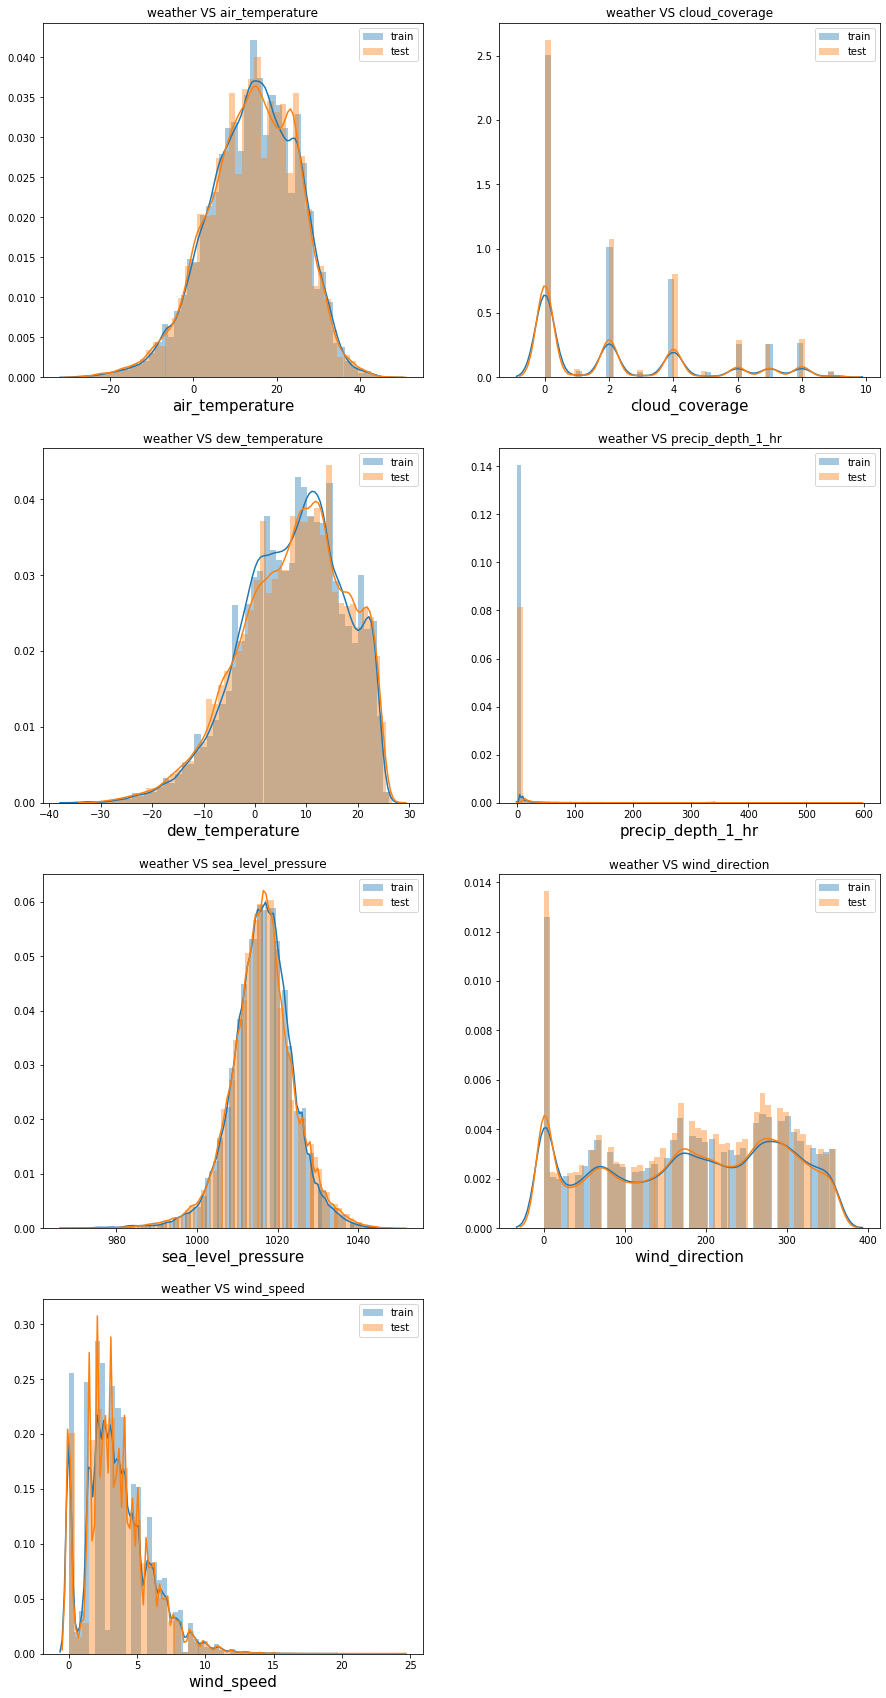

In [12]:
# function to use distplot in seaborn to compare test and train for weather
def compare_weather(ax, name):
    sb.distplot(df_weather_train[name].dropna(), ax = ax)
    sb.distplot(df_weather_test[name].dropna(), ax = ax)
    ax.set_title('weather VS ' + name)
    ax.set_xlabel(name, fontsize=15)
    ax.legend(['train', 'test'])
# make the images for comparation
fig, ((ax11, ax12),(ax13, ax14),(ax15,ax16),
      (ax17,ax18)) = plt.subplots(4, 2, sharex = False, sharey = False, figsize = (15,30))
weather_name = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 
                'sea_level_pressure', 'wind_direction', 'wind_speed']
fig_list = [ax11, ax12, ax13, ax14, ax15, ax16, ax17]
for i in range(7):
    compare_weather(fig_list[i], weather_name[i])
ax18.axis('off')
plt.savefig("./Output/png/weather_factors.png", bbox_inches = 'tight', dpi = 300)
plt.show()

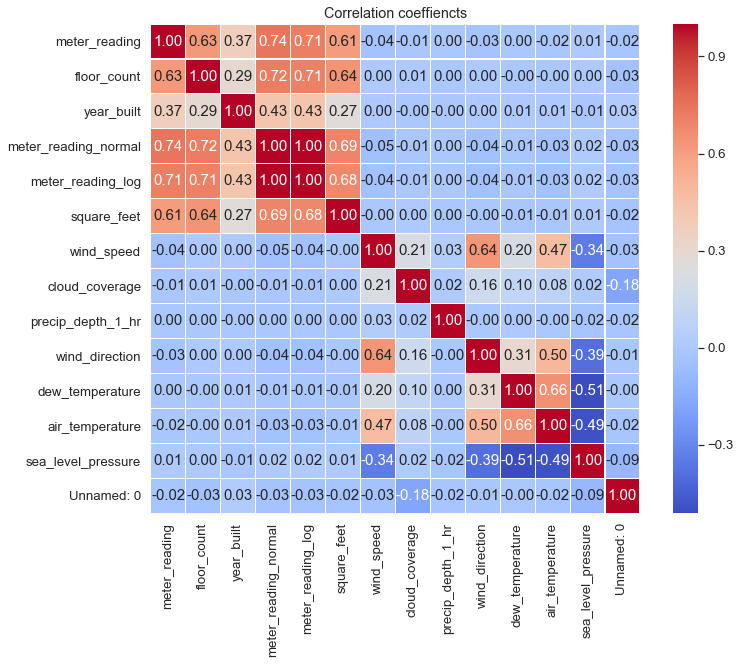

In [13]:
df_train_cor = df_train_merge.copy()
df_train_cor = df_train_cor.drop(columns = ['site_id', 'building_id', 'timestamp', 'meter'])
# correlation first as initial
cor_format = df_train_cor.corr()
# sort correlation around revenue
# here is a bug for plt so there is a cutoff and use ylim to fit it 
# but the order is different so use smallest and invert_xaxis to fix this bug
col_name = cor_format.nsmallest(15, 'meter_reading')['meter_reading'].index
# use np to make the list for the correlation
cor_num = np.corrcoef(df_train_cor[col_name].dropna(how = 'any').values.T)
# making the figures
plt.figure(figsize = (12,9))
sb.set(font_scale = 1.2)
ax = sb.heatmap(cor_num, cbar = True, annot = True, square = True, fmt = '.2f', 
                annot_kws = {'size': 15}, linewidth = 0.1, cmap = 'coolwarm',
                yticklabels = col_name.values, xticklabels = col_name.values)
plt.title("Correlation coeffiencts")
ax.invert_xaxis()
plt.ylim(0,len(cor_num))
plt.savefig("Output/png/correlation_heatmap.png", bbox_inches = 'tight', dpi = 300)
plt.show()

In [14]:
start_time = df_train_merge['timestamp'].min()
end_time = df_train_merge['timestamp'].max()
def building_meter_reading_plot(id_list, figname, start = start_time, end = end_time):
    fig, ax_list = plt.subplots(len(id_list), 1, sharex = False, sharey = False, figsize = (15,len(id_list)*7))
    for i,axes in enumerate(ax_list):
        data = df_train[df_train['building_id'] == id_list[i]].set_index('timestamp').loc[start: end]
        data.plot(y = 'meter_reading', ax = axes, label = i, legend = False)
        axes.set_title('Building id %s'% i)
    plt.savefig("Output/png/" + figname, bbox_inches = 'tight', dpi = 300)
    plt.show()

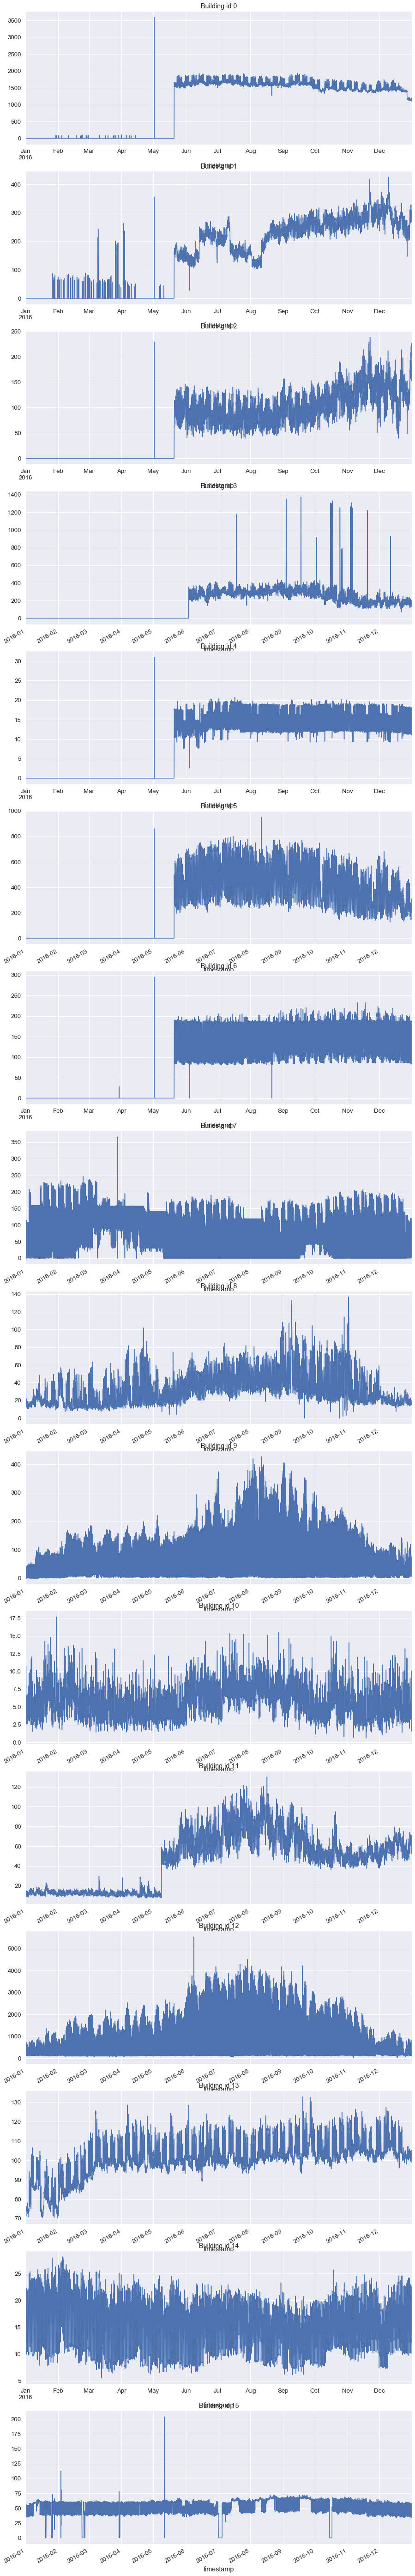

In [15]:
primary_use = list(df_train_merge['primary_use'].unique())
building_id = []
for i in primary_use:
    temp_list = random.choice(list(df_train_merge.loc[df_train_merge['primary_use'] == i, :]['building_id'])[:5])
    building_id.append(temp_list)
building_meter_reading_plot(id_list = building_id, figname = 'all_time_random_building_id_meter_reading.png')

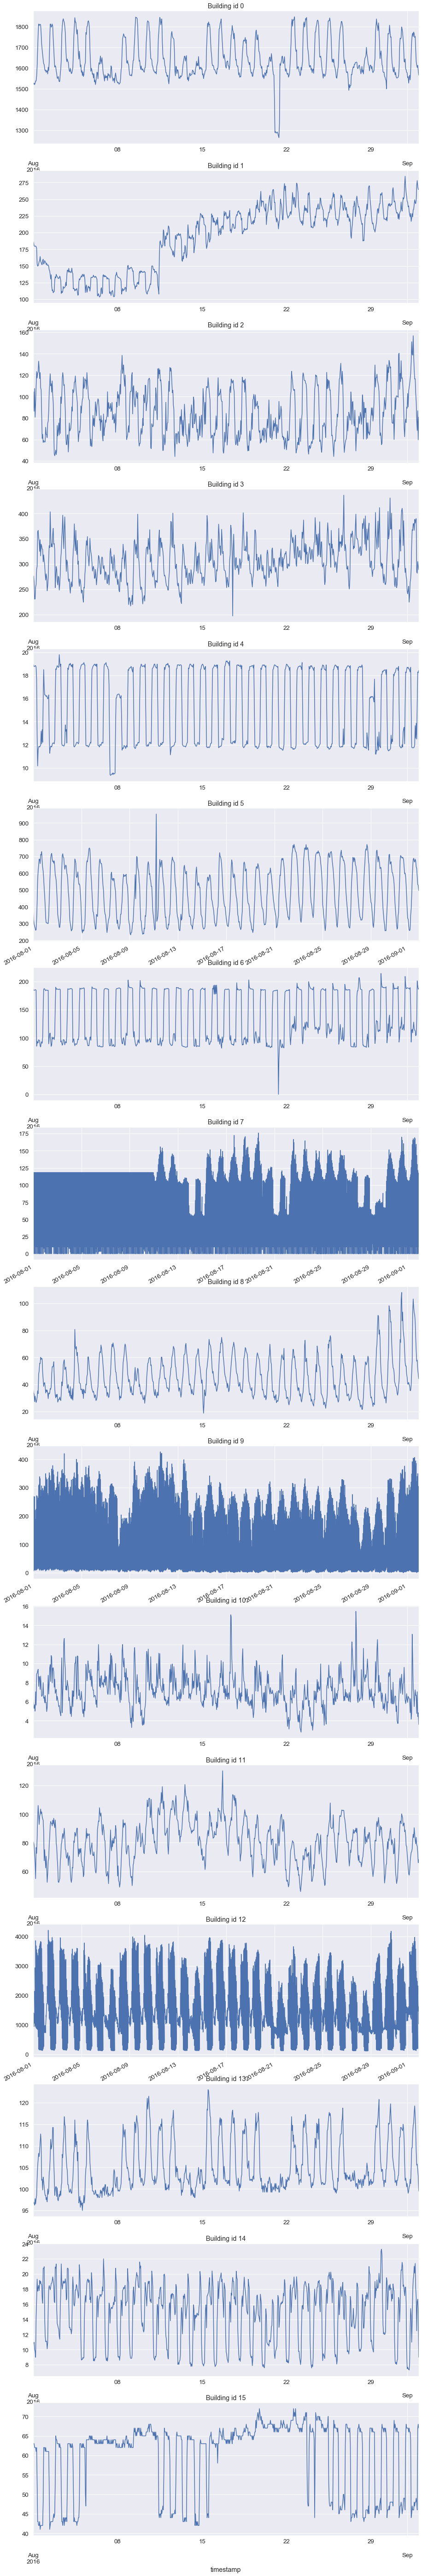

In [16]:
building_meter_reading_plot(id_list = building_id, start = '2016-08-01', end = '2016-09-01',
                            figname = 'Auguest_random_building_id_meter_reading.png')

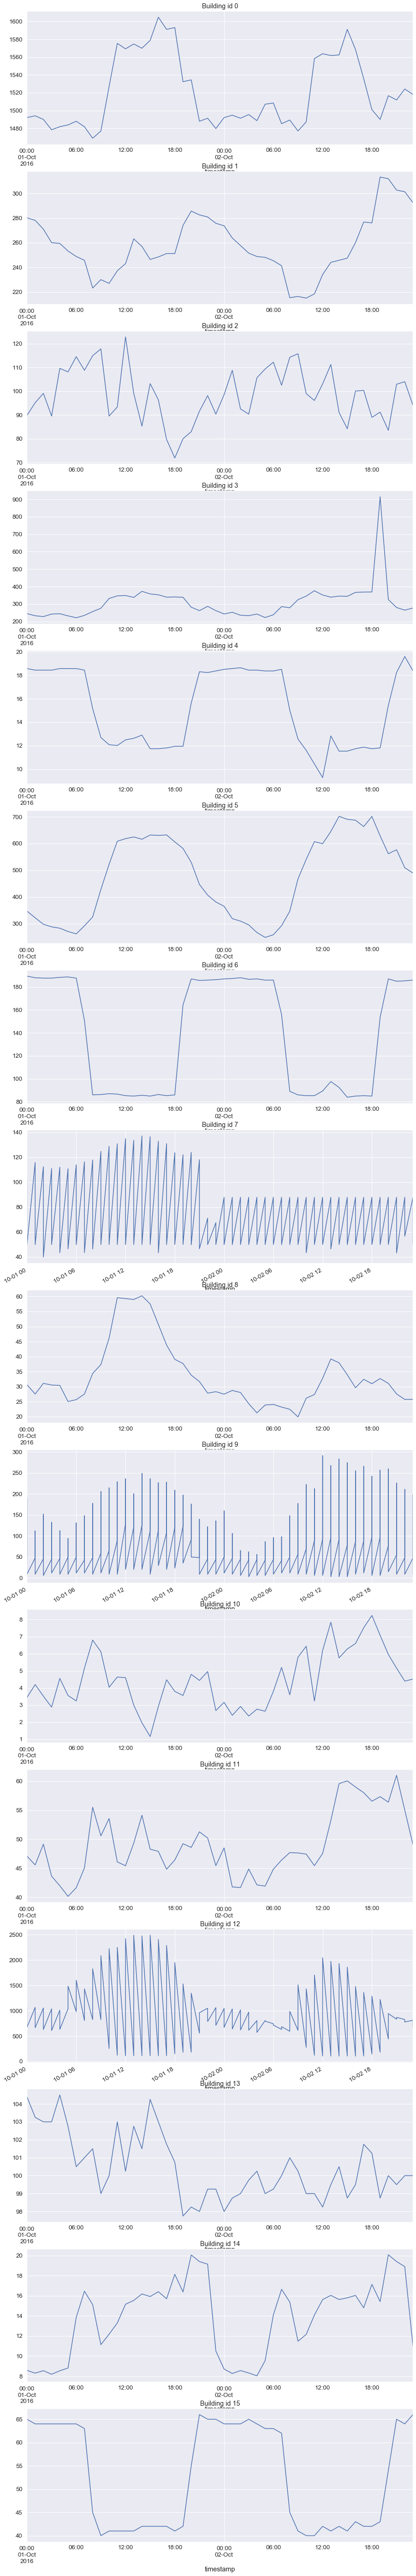

In [17]:
building_meter_reading_plot(id_list = building_id, start = '2016-10-01', end = '2016-10-02',
                            figname = '10-1_random_building_id_meter_reading.png')

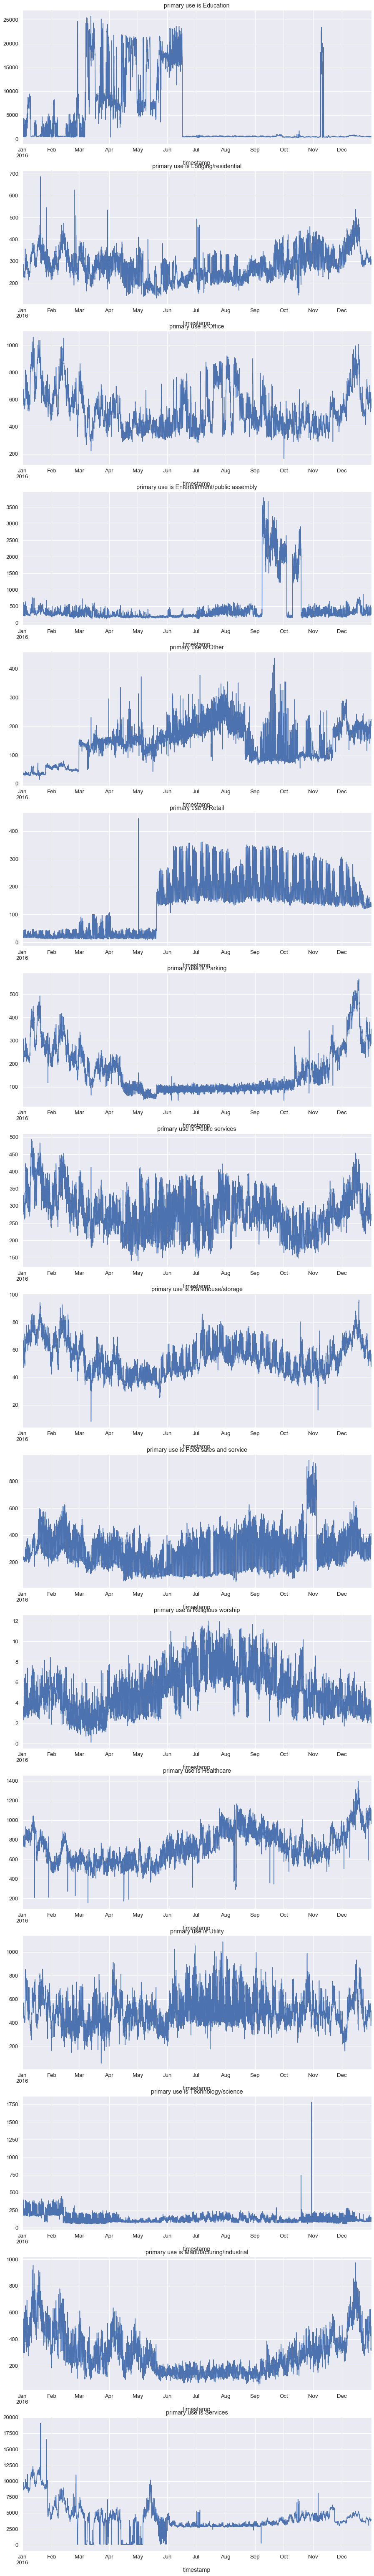

In [18]:
fig, ax_list = plt.subplots(len(primary_use), 1, sharex = False, sharey = False, figsize = (15,len(primary_use)*7))
for i,axes in enumerate(ax_list):
    df_temp = df_train_merge[df_train_merge['primary_use'] == primary_use[i]]
    df_temp = df_temp.groupby('timestamp').meter_reading.mean()
    df_temp.plot(ax = axes, label = i, legend = False)
    axes.set_title('primary use is %s'% primary_use[i])
plt.savefig("Output/png/differnt_primary_use_meter_reading.png", bbox_inches = 'tight', dpi = 300)
plt.show()

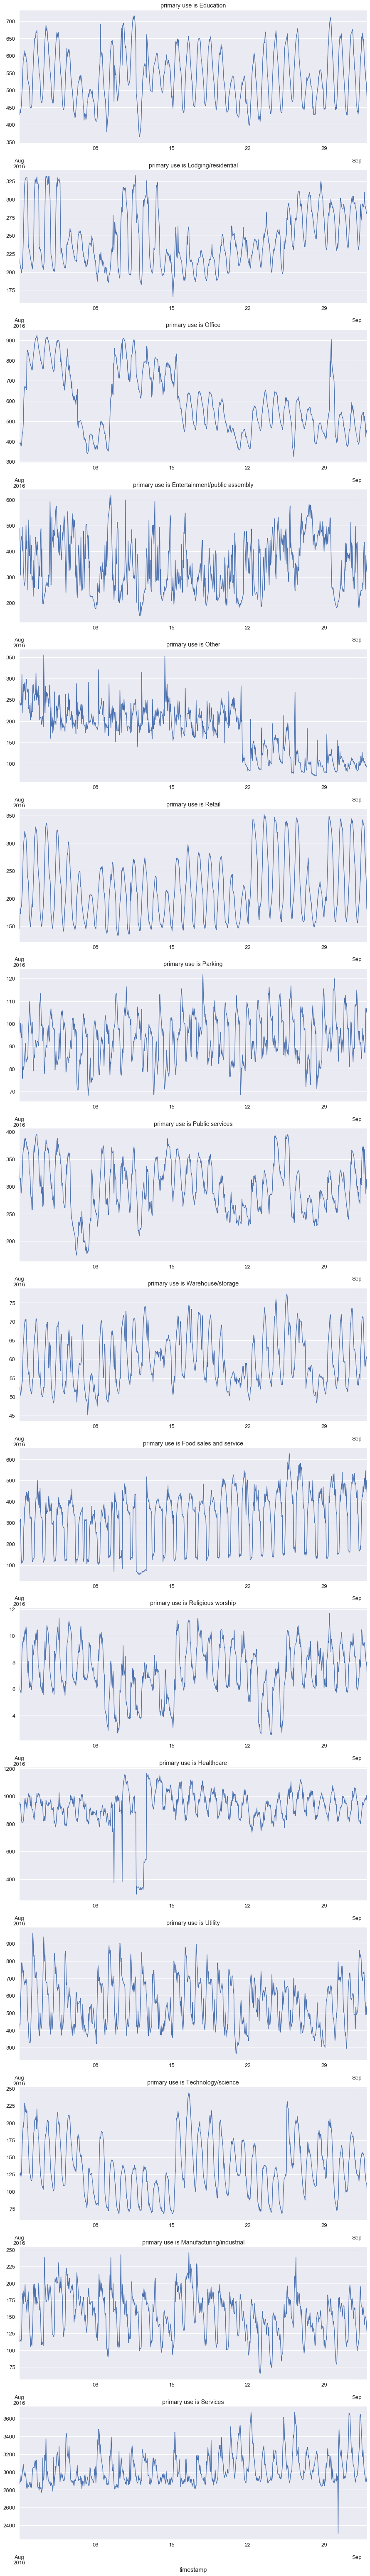

In [19]:
fig, ax_list = plt.subplots(len(primary_use), 1, sharex = False, sharey = False, figsize = (15,len(primary_use)*7))
for i,axes in enumerate(ax_list):
    df_temp = df_train_merge[df_train_merge['primary_use'] == primary_use[i]]
    df_temp = df_temp.groupby('timestamp').meter_reading.mean().loc['2016-08-01': '2016-09-01']
    df_temp.plot(ax = axes, label = i, legend = False)
    axes.set_title('primary use is %s'% primary_use[i])
plt.savefig("Output/png/Auguest_differnt_primary_use_meter_reading.png", bbox_inches = 'tight', dpi = 300)
plt.show()

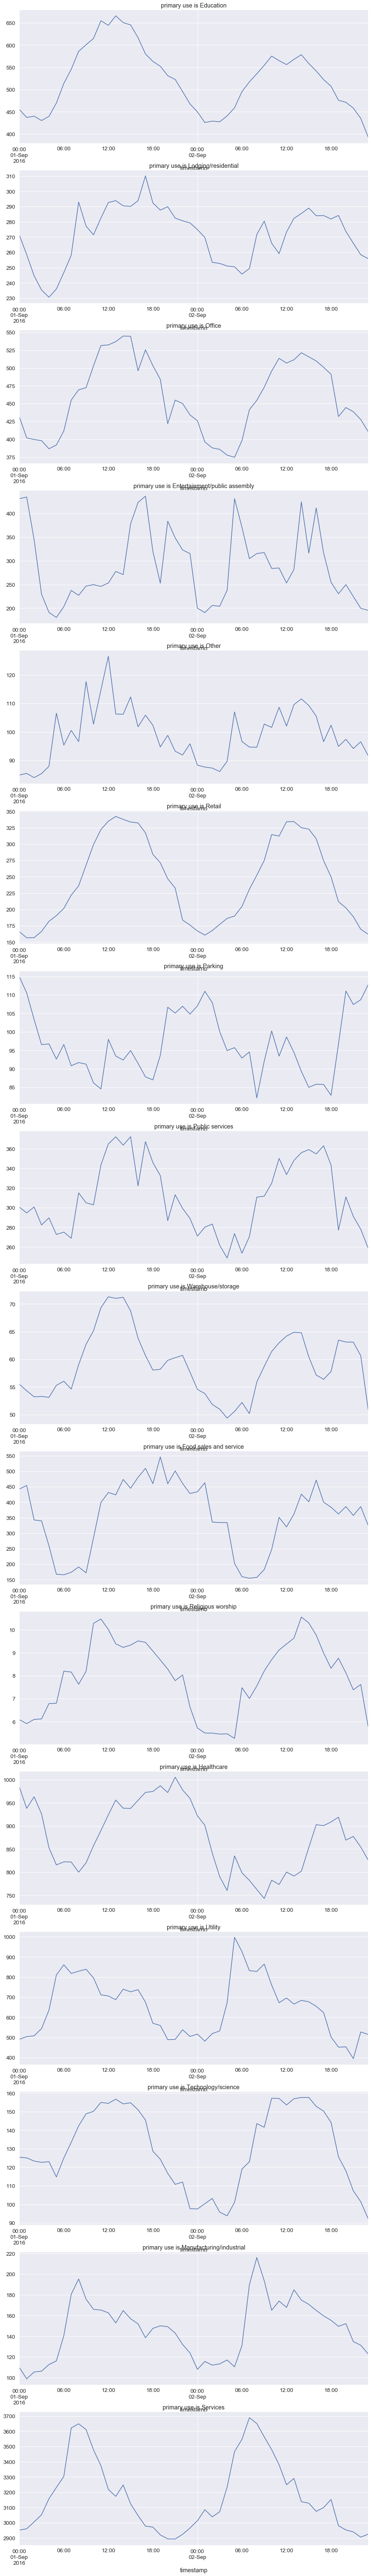

In [20]:
fig, ax_list = plt.subplots(len(primary_use), 1, sharex = False, sharey = False, figsize = (15,len(primary_use)*7))
for i,axes in enumerate(ax_list):
    df_temp = df_train_merge[df_train_merge['primary_use'] == primary_use[i]]
    df_temp = df_temp.groupby('timestamp').meter_reading.mean().loc['2016-09-01': '2016-09-02']
    df_temp.plot(ax = axes, label = i, legend = False)
    axes.set_title('primary use is %s'% primary_use[i])
plt.savefig("Output/png/09-01_primary_use_meter_reading.png", bbox_inches = 'tight', dpi = 300)
plt.show()